In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Lista dei file da analizzare
file_names = [f.stem for f in Path("data").glob("*.txt")]

In [2]:
def parse_log_file(filename):
    """
    Estrae informazioni dai log SSH (solo password authentication)
    """
    data = []
    
    try:
        with open(f"data/{filename}.txt", "r") as f:
            for line in f:
                line = line.strip()
                if "Accepted password for" in line:
                    parts = line.split()
                    
                    # Estrai data/ora (formato: Nov 11 08:36:21)
                    month = parts[0]
                    day = parts[1]
                    time = parts[2]
                    
                    # Estrai hostname del server
                    hostname = parts[3]
                    
                    # Estrai IP
                    ip_index = parts.index("from") + 1
                    ip = parts[ip_index]
                    
                    # Estrai porta
                    port_index = parts.index("port") + 1
                    port = parts[port_index]
                    
                    data.append({
                        'server': filename,
                        'month': month,
                        'day': int(day),
                        'time': time,
                        'hostname': hostname,
                        'ip': ip,
                        'port': int(port),
                        'raw_line': line
                    })
    except FileNotFoundError:
        print(f"⚠️ File {filename}.txt non trovato")
    
    return data

print("✓ Funzione di parsing definita")

✓ Funzione di parsing definita


In [3]:
# Carica tutti i file
all_data = []
for filename in file_names:
    file_data = parse_log_file(filename)
    all_data.extend(file_data)
    print(f"📁 {filename}.txt: {len(file_data)} connessioni via password")

# Crea DataFrame
df = pd.DataFrame(all_data)

# Converti il timestamp in datetime (assumendo anno corrente)
current_year = datetime.now().year
df['datetime'] = pd.to_datetime(
    df['month'] + ' ' + df['day'].astype(str) + ' ' + df['time'] + f' {current_year}',
    format='%b %d %H:%M:%S %Y'
)

# Estrai informazioni temporali
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['datetime'].dt.day_name()
df['date'] = df['datetime'].dt.date

print(f"\n📊 Dataset totale: {len(df)} connessioni da {df['server'].nunique()} server")
print(f"📅 Periodo: {df['datetime'].min()} → {df['datetime'].max()}")

📁 bots.txt: 3482 connessioni via password
📁 cafe.txt: 3405 connessioni via password
📁 fixyoutube.txt: 4254 connessioni via password
📁 public.txt: 3401 connessioni via password

📊 Dataset totale: 14542 connessioni da 4 server
📅 Periodo: 2025-11-11 00:35:39 → 2025-12-03 17:59:22


In [4]:
print("=" * 60)
print("📈 STATISTICHE GENERALI")
print("=" * 60)

print(f"\n🔢 Totale connessioni: {len(df)}")
print(f"🖥️  Server analizzati: {df['server'].nunique()}")
print(f"🌐 IP unici: {df['ip'].nunique()}")
print(f"📅 Giorni con attività: {df['date'].nunique()}")

print("\n" + "─" * 60)
print("🖥️  CONNESSIONI PER SERVER:")
print("─" * 60)
server_stats = df['server'].value_counts()
for server, count in server_stats.items():
    pct = (count / len(df)) * 100
    print(f"  {server:15s}: {count:5d} ({pct:5.1f}%)")

print("\n" + "─" * 60)
print("🌐 TOP 10 IP PIÙ ATTIVI:")
print("─" * 60)
top_ips = df['ip'].value_counts().head(10)
for ip, count in top_ips.items():
    servers = df[df['ip'] == ip]['server'].unique()
    print(f"  {ip:15s}: {count:4d} connessioni su {len(servers)} server")

📈 STATISTICHE GENERALI

🔢 Totale connessioni: 14542
🖥️  Server analizzati: 4
🌐 IP unici: 50
📅 Giorni con attività: 23

────────────────────────────────────────────────────────────
🖥️  CONNESSIONI PER SERVER:
────────────────────────────────────────────────────────────
  fixyoutube     :  4254 ( 29.3%)
  bots           :  3482 ( 23.9%)
  cafe           :  3405 ( 23.4%)
  public         :  3401 ( 23.4%)

────────────────────────────────────────────────────────────
🌐 TOP 10 IP PIÙ ATTIVI:
────────────────────────────────────────────────────────────
  91.215.85.88   : 4843 connessioni su 4 server
  45.140.17.88   : 1015 connessioni su 4 server
  77.83.207.83   :  670 connessioni su 2 server
  77.83.207.82   :  591 connessioni su 2 server
  77.232.37.22   :  312 connessioni su 4 server
  185.173.38.141 :  293 connessioni su 4 server
  208.69.78.179  :  293 connessioni su 3 server
  185.173.37.38  :  288 connessioni su 4 server
  77.232.38.170  :  285 connessioni su 4 server
  77.232.38.102 

In [5]:
print("\n" + "=" * 60)
print("⏰ ANALISI TEMPORALE")
print("=" * 60)

# Attività per giorno
print("\n📅 CONNESSIONI PER GIORNO:")
print("─" * 60)
daily_activity = df.groupby('date').size().sort_values(ascending=False)
for date, count in daily_activity.head(10).items():
    day_name = pd.to_datetime(date).strftime('%A')
    print(f"  {date} ({day_name}): {count:4d} connessioni")

# Attività per ora del giorno
print("\n🕐 DISTRIBUZIONE ORARIA:")
print("─" * 60)
hourly_activity = df['hour'].value_counts().sort_index()
for hour, count in hourly_activity.items():
    bar = '█' * (count // 10)
    print(f"  {hour:02d}:00 - {hour:02d}:59 | {bar} ({count})")

# Attività per giorno della settimana
print("\n📆 DISTRIBUZIONE SETTIMANALE:")
print("─" * 60)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_activity = df['weekday'].value_counts().reindex(weekday_order, fill_value=0)
for day, count in weekday_activity.items():
    pct = (count / len(df)) * 100
    print(f"  {day:10s}: {count:4d} ({pct:5.1f}%)")


⏰ ANALISI TEMPORALE

📅 CONNESSIONI PER GIORNO:
────────────────────────────────────────────────────────────
  2025-11-28 (Friday): 1535 connessioni
  2025-11-24 (Monday): 1218 connessioni
  2025-11-14 (Friday):  920 connessioni
  2025-11-25 (Tuesday):  893 connessioni
  2025-11-13 (Thursday):  723 connessioni
  2025-11-15 (Saturday):  712 connessioni
  2025-11-19 (Wednesday):  653 connessioni
  2025-11-27 (Thursday):  616 connessioni
  2025-11-23 (Sunday):  612 connessioni
  2025-11-20 (Thursday):  550 connessioni

🕐 DISTRIBUZIONE ORARIA:
────────────────────────────────────────────────────────────
  00:00 - 00:59 | ██████████████████████████████████████████████████ (505)
  01:00 - 01:59 | ███████████████████████████████████████████████████████████████████████████ (752)
  02:00 - 02:59 | ███████████████████████████████████████████████████████████ (594)
  03:00 - 03:59 | █████████████████████████████████████████████████████████████ (612)
  04:00 - 04:59 | ██████████████████████████████

In [6]:
print("\n" + "=" * 60)
print("🔗 ANALISI INCROCIATA SERVER-IP")
print("=" * 60)

# IP che accedono a più server
ip_server_counts = df.groupby('ip')['server'].nunique().sort_values(ascending=False)
multi_server_ips = ip_server_counts[ip_server_counts > 1]

print(f"\n🌐 IP che accedono a più server: {len(multi_server_ips)}")
print("─" * 60)
for ip, server_count in multi_server_ips.head(10).items():
    total_connections = len(df[df['ip'] == ip])
    servers = ', '.join(df[df['ip'] == ip]['server'].unique())
    print(f"  {ip:15s}: {server_count} server, {total_connections} connessioni")
    print(f"                   └─ Server: {servers}")

# Matrice server-IP
print("\n📊 MATRICE CONNESSIONI (Server x Top 5 IP):")
print("─" * 60)
top5_ips = df['ip'].value_counts().head(5).index
matrix = df[df['ip'].isin(top5_ips)].pivot_table(
    index='server', 
    columns='ip', 
    aggfunc='size', 
    fill_value=0
)
print(matrix)


🔗 ANALISI INCROCIATA SERVER-IP

🌐 IP che accedono a più server: 48
────────────────────────────────────────────────────────────
  162.248.161.245: 4 server, 189 connessioni
                   └─ Server: bots, cafe, fixyoutube, public
  185.173.37.38  : 4 server, 288 connessioni
                   └─ Server: bots, cafe, fixyoutube, public
  185.244.181.51 : 4 server, 68 connessioni
                   └─ Server: bots, cafe, fixyoutube, public
  185.173.37.63  : 4 server, 70 connessioni
                   └─ Server: bots, cafe, fixyoutube, public
  185.173.37.83  : 4 server, 240 connessioni
                   └─ Server: bots, cafe, fixyoutube, public
  185.173.38.141 : 4 server, 293 connessioni
                   └─ Server: bots, cafe, fixyoutube, public
  185.173.39.145 : 4 server, 127 connessioni
                   └─ Server: bots, cafe, fixyoutube, public
  185.173.39.170 : 4 server, 44 connessioni
                   └─ Server: bots, cafe, fixyoutube, public
  185.173.39.74  : 4 serve

In [7]:
print("\n" + "=" * 60)
print("🔍 PATTERN E ANOMALIE")
print("=" * 60)

# Connessioni consecutive dallo stesso IP
print("\n⚡ IP CON BURST DI ATTIVITÀ:")
print("─" * 60)
df_sorted = df.sort_values(['ip', 'datetime'])
df_sorted['time_diff'] = df_sorted.groupby('ip')['datetime'].diff().dt.total_seconds()

# Trova burst (connessioni ravvicinate)
burst_threshold = 300  # 5 minuti
bursts = df_sorted[df_sorted['time_diff'] < burst_threshold].groupby('ip').size()
bursts = bursts.sort_values(ascending=False)

for ip, burst_count in bursts.head(10).items():
    total = len(df[df['ip'] == ip])
    print(f"  {ip:15s}: {burst_count} connessioni ravvicinate (su {total} totali)")

# Porte più utilizzate
print("\n🚪 TOP 10 PORTE UTILIZZATE:")
print("─" * 60)
port_stats = df['port'].value_counts().head(10)
for port, count in port_stats.items():
    print(f"  Porta {port:5d}: {count:4d} utilizzi")


🔍 PATTERN E ANOMALIE

⚡ IP CON BURST DI ATTIVITÀ:
────────────────────────────────────────────────────────────
  91.215.85.88   : 2980 connessioni ravvicinate (su 4843 totali)
  45.140.17.88   : 723 connessioni ravvicinate (su 1015 totali)
  77.83.207.83   : 178 connessioni ravvicinate (su 670 totali)
  77.232.38.102  : 123 connessioni ravvicinate (su 277 totali)
  77.232.37.22   : 115 connessioni ravvicinate (su 312 totali)
  77.232.38.170  : 115 connessioni ravvicinate (su 285 totali)
  185.173.37.38  : 113 connessioni ravvicinate (su 288 totali)
  185.173.38.141 : 110 connessioni ravvicinate (su 293 totali)
  77.232.41.132  : 107 connessioni ravvicinate (su 275 totali)
  91.142.78.8    : 99 connessioni ravvicinate (su 224 totali)

🚪 TOP 10 PORTE UTILIZZATE:
────────────────────────────────────────────────────────────
  Porta  9188:    5 utilizzi
  Porta 52832:    4 utilizzi
  Porta 40206:    4 utilizzi
  Porta 62648:    4 utilizzi
  Porta 56758:    4 utilizzi
  Porta 36190:    4 ut

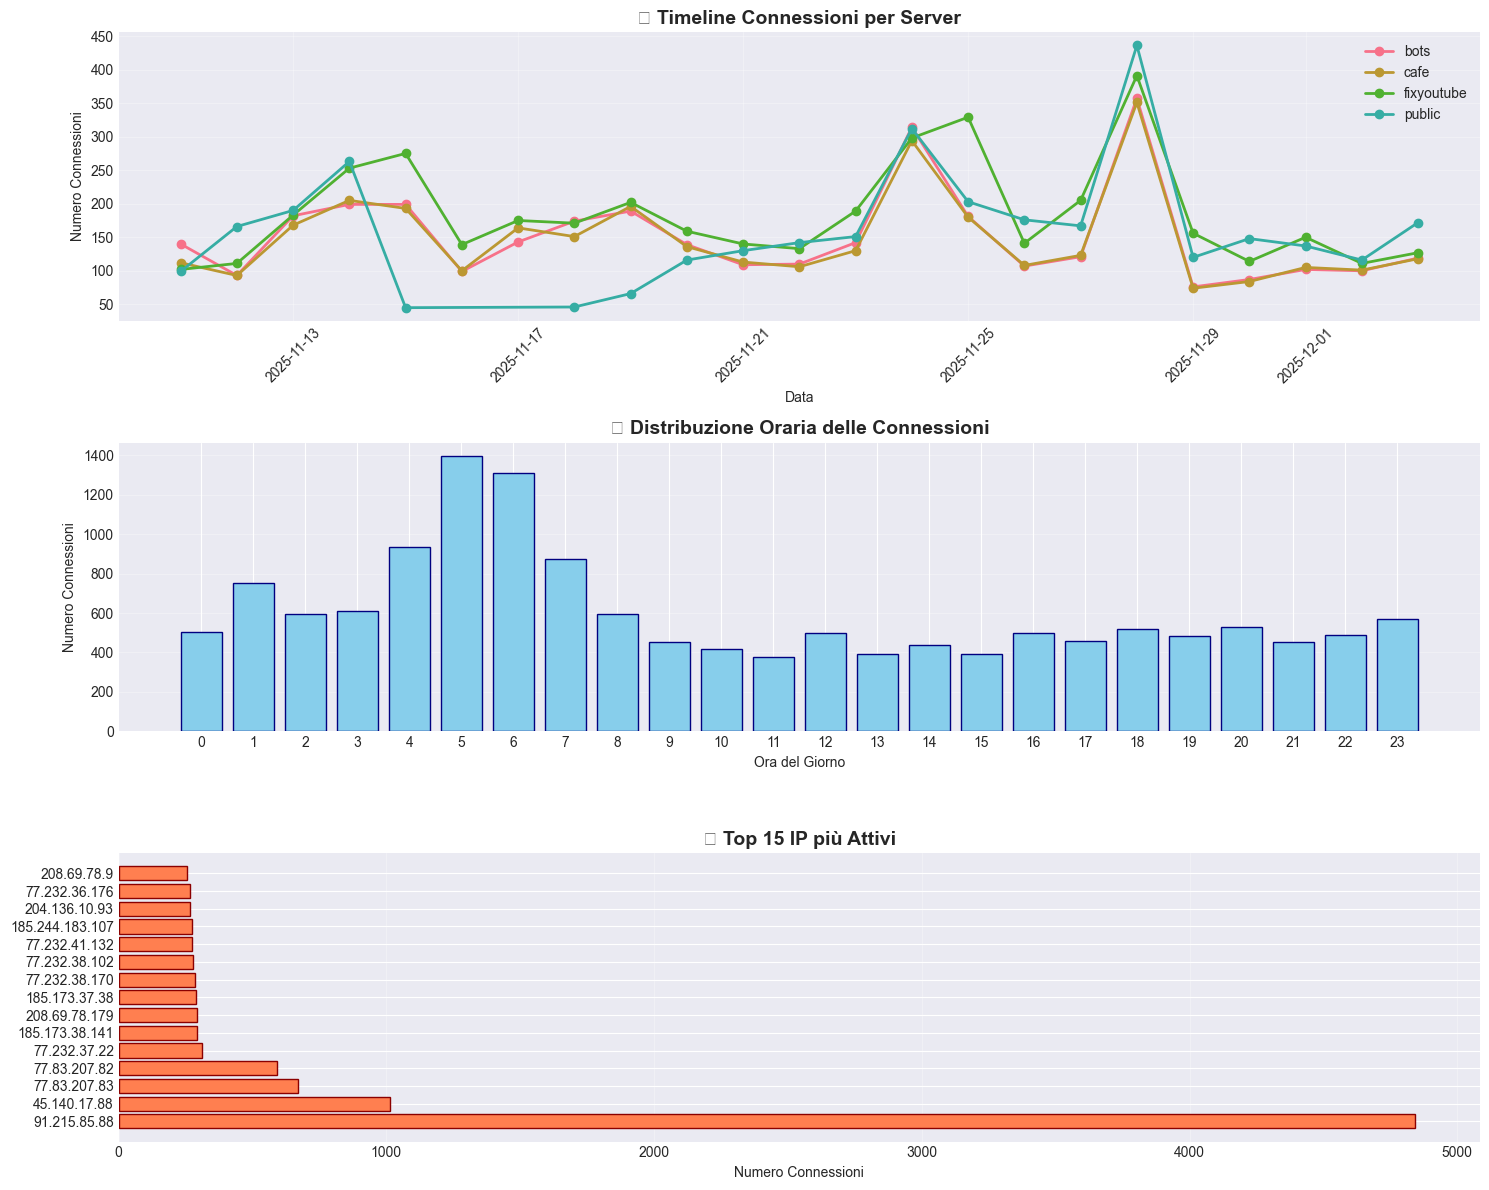

In [8]:
# Timeline delle connessioni
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Grafico 1: Connessioni nel tempo per server
for server in df['server'].unique():
    server_data = df[df['server'] == server].groupby('date').size()
    axes[0].plot(server_data.index, server_data.values, marker='o', label=server, linewidth=2)

axes[0].set_title('📈 Timeline Connessioni per Server', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Numero Connessioni')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Grafico 2: Distribuzione oraria
hourly_data = df['hour'].value_counts().sort_index()
axes[1].bar(hourly_data.index, hourly_data.values, color='skyblue', edgecolor='navy')
axes[1].set_title('🕐 Distribuzione Oraria delle Connessioni', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Ora del Giorno')
axes[1].set_ylabel('Numero Connessioni')
axes[1].set_xticks(range(24))
axes[1].grid(True, alpha=0.3, axis='y')

# Grafico 3: Top IP
top_ips_data = df['ip'].value_counts().head(15)
axes[2].barh(range(len(top_ips_data)), top_ips_data.values, color='coral', edgecolor='darkred')
axes[2].set_yticks(range(len(top_ips_data)))
axes[2].set_yticklabels(top_ips_data.index)
axes[2].set_title('🌐 Top 15 IP più Attivi', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Numero Connessioni')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

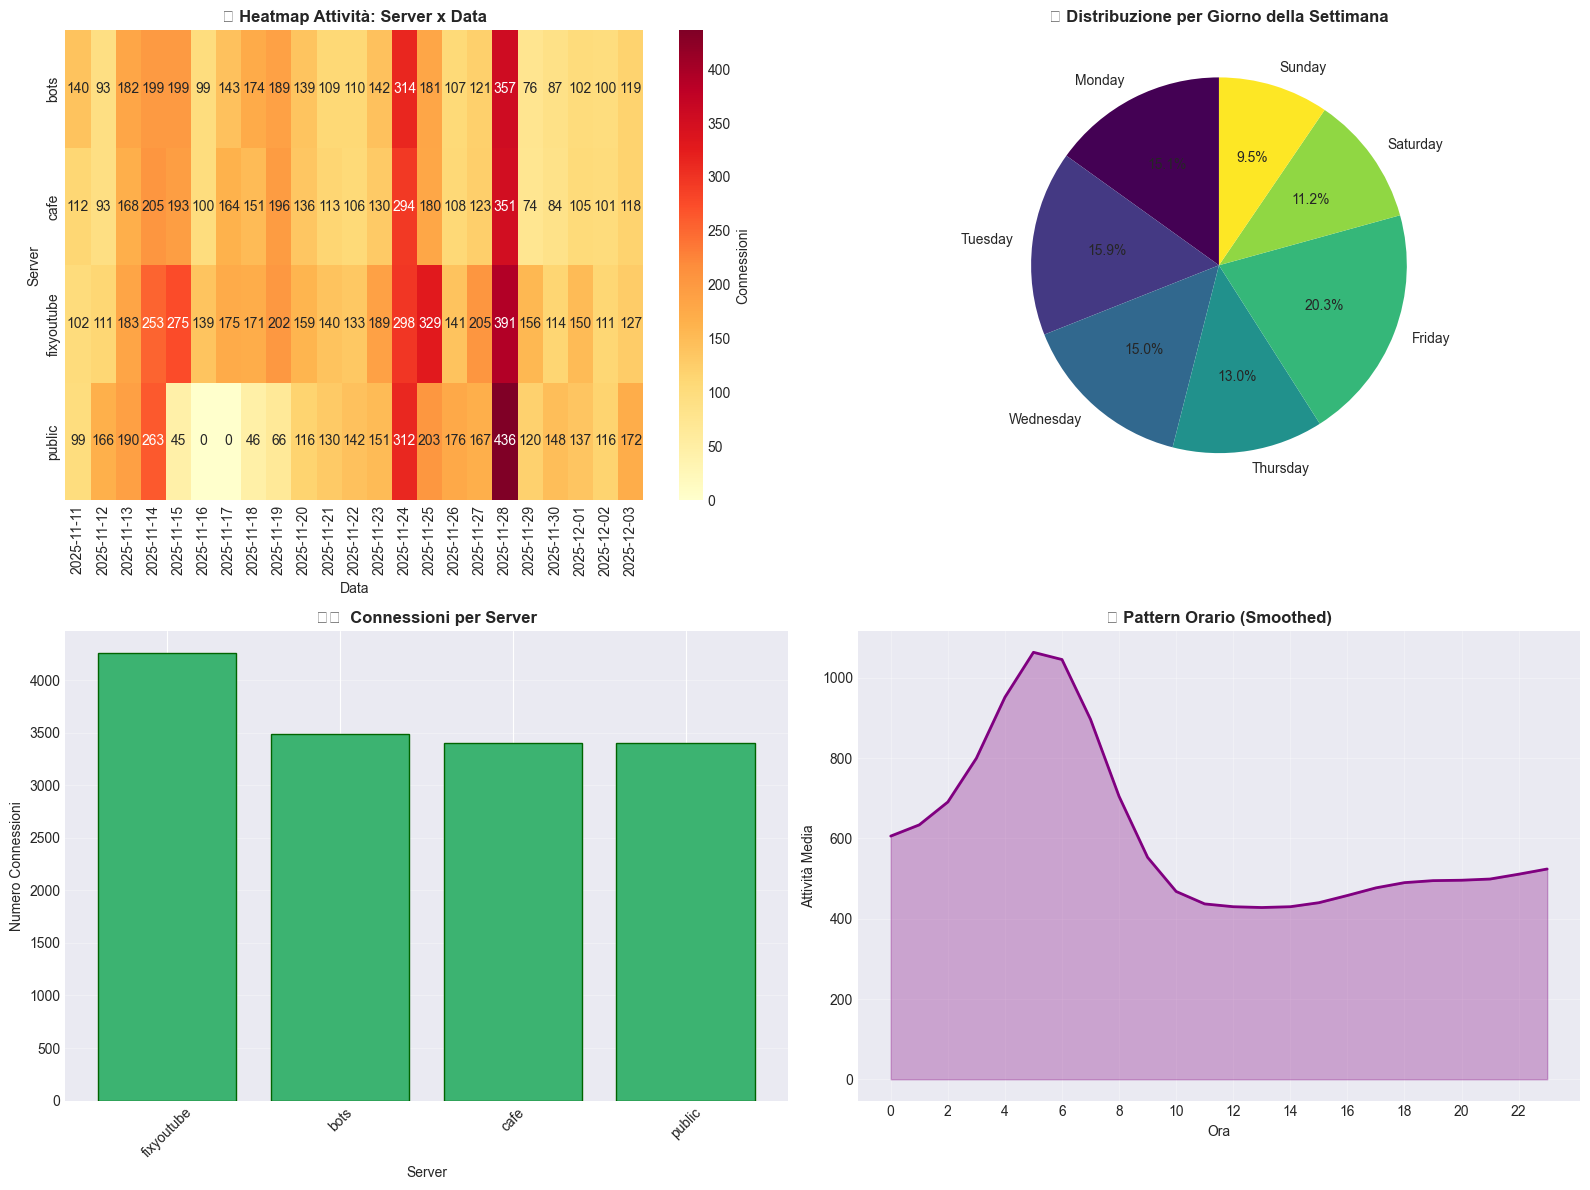

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Heatmap Server x Giorno
heatmap_data = df.pivot_table(
    index='server',
    columns='date',
    aggfunc='size',
    fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0, 0], cbar_kws={'label': 'Connessioni'})
axes[0, 0].set_title('🔥 Heatmap Attività: Server x Data', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Server')

# Grafico 2: Distribuzione settimanale
weekday_data = df['weekday'].value_counts().reindex(weekday_order, fill_value=0)
colors = plt.cm.viridis(np.linspace(0, 1, len(weekday_data)))
axes[0, 1].pie(weekday_data.values, labels=weekday_data.index, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 1].set_title('📆 Distribuzione per Giorno della Settimana', fontsize=12, fontweight='bold')

# Grafico 3: Connessioni per server
server_data = df['server'].value_counts()
axes[1, 0].bar(server_data.index, server_data.values, color='mediumseagreen', edgecolor='darkgreen')
axes[1, 0].set_title('🖥️  Connessioni per Server', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Server')
axes[1, 0].set_ylabel('Numero Connessioni')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Grafico 4: Attività oraria con smooth
hourly_smooth = gaussian_filter1d(hourly_data.values, sigma=1.5)
axes[1, 1].fill_between(hourly_data.index, hourly_smooth, alpha=0.3, color='purple')
axes[1, 1].plot(hourly_data.index, hourly_smooth, color='purple', linewidth=2)
axes[1, 1].set_title('⏰ Pattern Orario (Smoothed)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Ora')
axes[1, 1].set_ylabel('Attività Media')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

In [10]:
# Salva statistiche in file CSV
print("💾 Esportazione risultati...")

# 1. Summary generale
summary = pd.DataFrame({
    'Metrica': [
        'Totale Connessioni',
        'Server Unici',
        'IP Unici',
        'Giorni Attivi',
        'Periodo Analisi'
    ],
    'Valore': [
        len(df),
        df['server'].nunique(),
        df['ip'].nunique(),
        df['date'].nunique(),
        f"{df['datetime'].min()} → {df['datetime'].max()}"
    ]
})
summary.to_csv('summary_statistics.csv', index=False)
print("  ✓ summary_statistics.csv")

# 2. Top IP con dettagli
top_ip_details = df.groupby('ip').agg({
    'server': lambda x: len(x.unique()),
    'datetime': ['min', 'max', 'count']
}).round(2)
top_ip_details.columns = ['Server_Unici', 'Prima_Connessione', 'Ultima_Connessione', 'Totale_Connessioni']
top_ip_details = top_ip_details.sort_values('Totale_Connessioni', ascending=False)
top_ip_details.to_csv('top_ip_analysis.csv')
print("  ✓ top_ip_analysis.csv")

# 3. Attività giornaliera
daily_stats = df.groupby(['date', 'server']).size().reset_index(name='connessioni')
daily_stats.to_csv('daily_activity.csv', index=False)
print("  ✓ daily_activity.csv")

# 4. Dataset completo pulito
df_export = df[['datetime', 'server', 'ip', 'port', 'hour', 'weekday']].copy()
df_export.to_csv('full_dataset.csv', index=False)
print("  ✓ full_dataset.csv")

print("\n✅ Analisi completata!")

💾 Esportazione risultati...
  ✓ summary_statistics.csv
  ✓ top_ip_analysis.csv
  ✓ daily_activity.csv
  ✓ full_dataset.csv

✅ Analisi completata!
